# <h1 style="color:turquoise;">Deliverable1: Segmentación de objetos</h1>

## Dataset

En primer lugar, vamos a clonar el repositorio contenedor de las imágenes a estudiar.

Este repositorio contiene imágenes de corderos y su máscara real segmentada (imagen binaria)

In [17]:
!git clone https://github.com/ULE-Informatica-2024-2025/VICO_lamb

fatal: destination path 'VICO_lamb' already exists and is not an empty directory.


## Dependencias

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

## Lectura de imágenes

Antes de estudiar las imágenes, es necesario conocer de cuántas imágenes disponemos y el tamaño de las mismas.

In [19]:
def contar_imagenes_y_tamanos(carpeta, extensiones=['.jpg', '.jpeg', '.png', '.bmp', '.gif']):
    archivos = os.listdir(carpeta)
    
    imagenes = [archivo for archivo in archivos if os.path.splitext(archivo)[1].lower() in extensiones]
    
    numero_imagenes = len(imagenes)
    
    dimensiones = {}
    for imagen in imagenes:
        ruta_imagen = os.path.join(carpeta, imagen)
        with Image.open(ruta_imagen) as img:
            dimensiones[imagen] = img.size
    
    return numero_imagenes, dimensiones

def info_images(path):
    numero_imagenes, dimensiones = contar_imagenes_y_tamanos(path)

    print(f" - Número de imágenes en la carpeta: {numero_imagenes}")

    if len(set(dimensiones.values())) == 1:
        dimension_unica = next(iter(dimensiones.values()))
        print(f" - Tamaño de todas las imágenes: {dimension_unica}")
    else:
        print(" - Tamaños de las imágenes:")
        for imagen, tamano in dimensiones.items():
            print(f"{imagen}: {tamano}")

In [20]:
path_dataset_color = '.\\VICO_lamb\\color\\'
path_dataset_mask = '.\\VICO_lamb\\mask'

print("Información de las imágenes a color")
info_images(path_dataset_color)
print("Información de las imágenes en blanco y negro")
info_images(path_dataset_mask)

Información de las imágenes a color
 - Número de imágenes en la carpeta: 24
 - Tamaño de todas las imágenes: (848, 480)
Información de las imágenes en blanco y negro
 - Número de imágenes en la carpeta: 24
 - Tamaño de todas las imágenes: (848, 480)


Tenemos 24 imágenes y todas del mismo tamaño. Definimos dos constantes para esta información.

In [21]:
NUM_IMAGES = 24
DIMENSION = (848,480)

Ahora vamos a procesar cada una de las imágenes y vamos a representar un histograma de las mismas. Para esto, es necesario leer las imágenes a color y en escala de grises.

In [22]:
def mostrar_histogramas(path, color_type):
    # Obtener lista de archivos en la carpeta
    archivos = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    extensiones = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    imagenes = [f for f in archivos if os.path.splitext(f)[1].lower() in extensiones]
    
    # Crear subplots
    fig, axs = plt.subplots(6, 4, figsize=(20, 30))
    axs = axs.ravel() 
    
    for i, imagen in enumerate(imagenes[:NUM_IMAGES]):
        ruta_imagen = os.path.join(path, imagen)
        
        axs[i].set_title(f'Histograma {i}')
        axs[i].set_xlabel('Pixel Intensity')
        axs[i].set_ylabel('Number of Pixels')

        if color_type == 'bn':
            # Cargar imagen en escala de grises
            image = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
            # Calcular histograma
            hist = cv2.calcHist([image], [0], None, [256], [0, 256])
            # Mostrar histograma
            axs[i].bar(range(256), hist.flatten(), width=1.0)
            axs[i].set_xlim([0, 256])
        elif color_type == 'color':
            # Cargar imagen en color y convertir a RGB
            image = cv2.imread(ruta_imagen)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Calcular histogramas para cada canal de color
            hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])
            hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256])
            hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256])
            # Mostrar histogramas
            axs[i].plot(hist_r.flatten(),color='red', alpha = 0.6, label='Red')
            axs[i].plot(hist_g.flatten(),color='green', alpha = 0.6, label='Green')
            axs[i].plot(hist_b.flatten(),color='blue', alpha = 0.6, label='Blue')
            axs[i].set_xlim([0, 256])
            axs[i].legend()
        else:
            print("Tipo de color no reconocido. Usa 'blanco_y_negro' o 'color'.")
            return
    
    plt.tight_layout()
    plt.show()

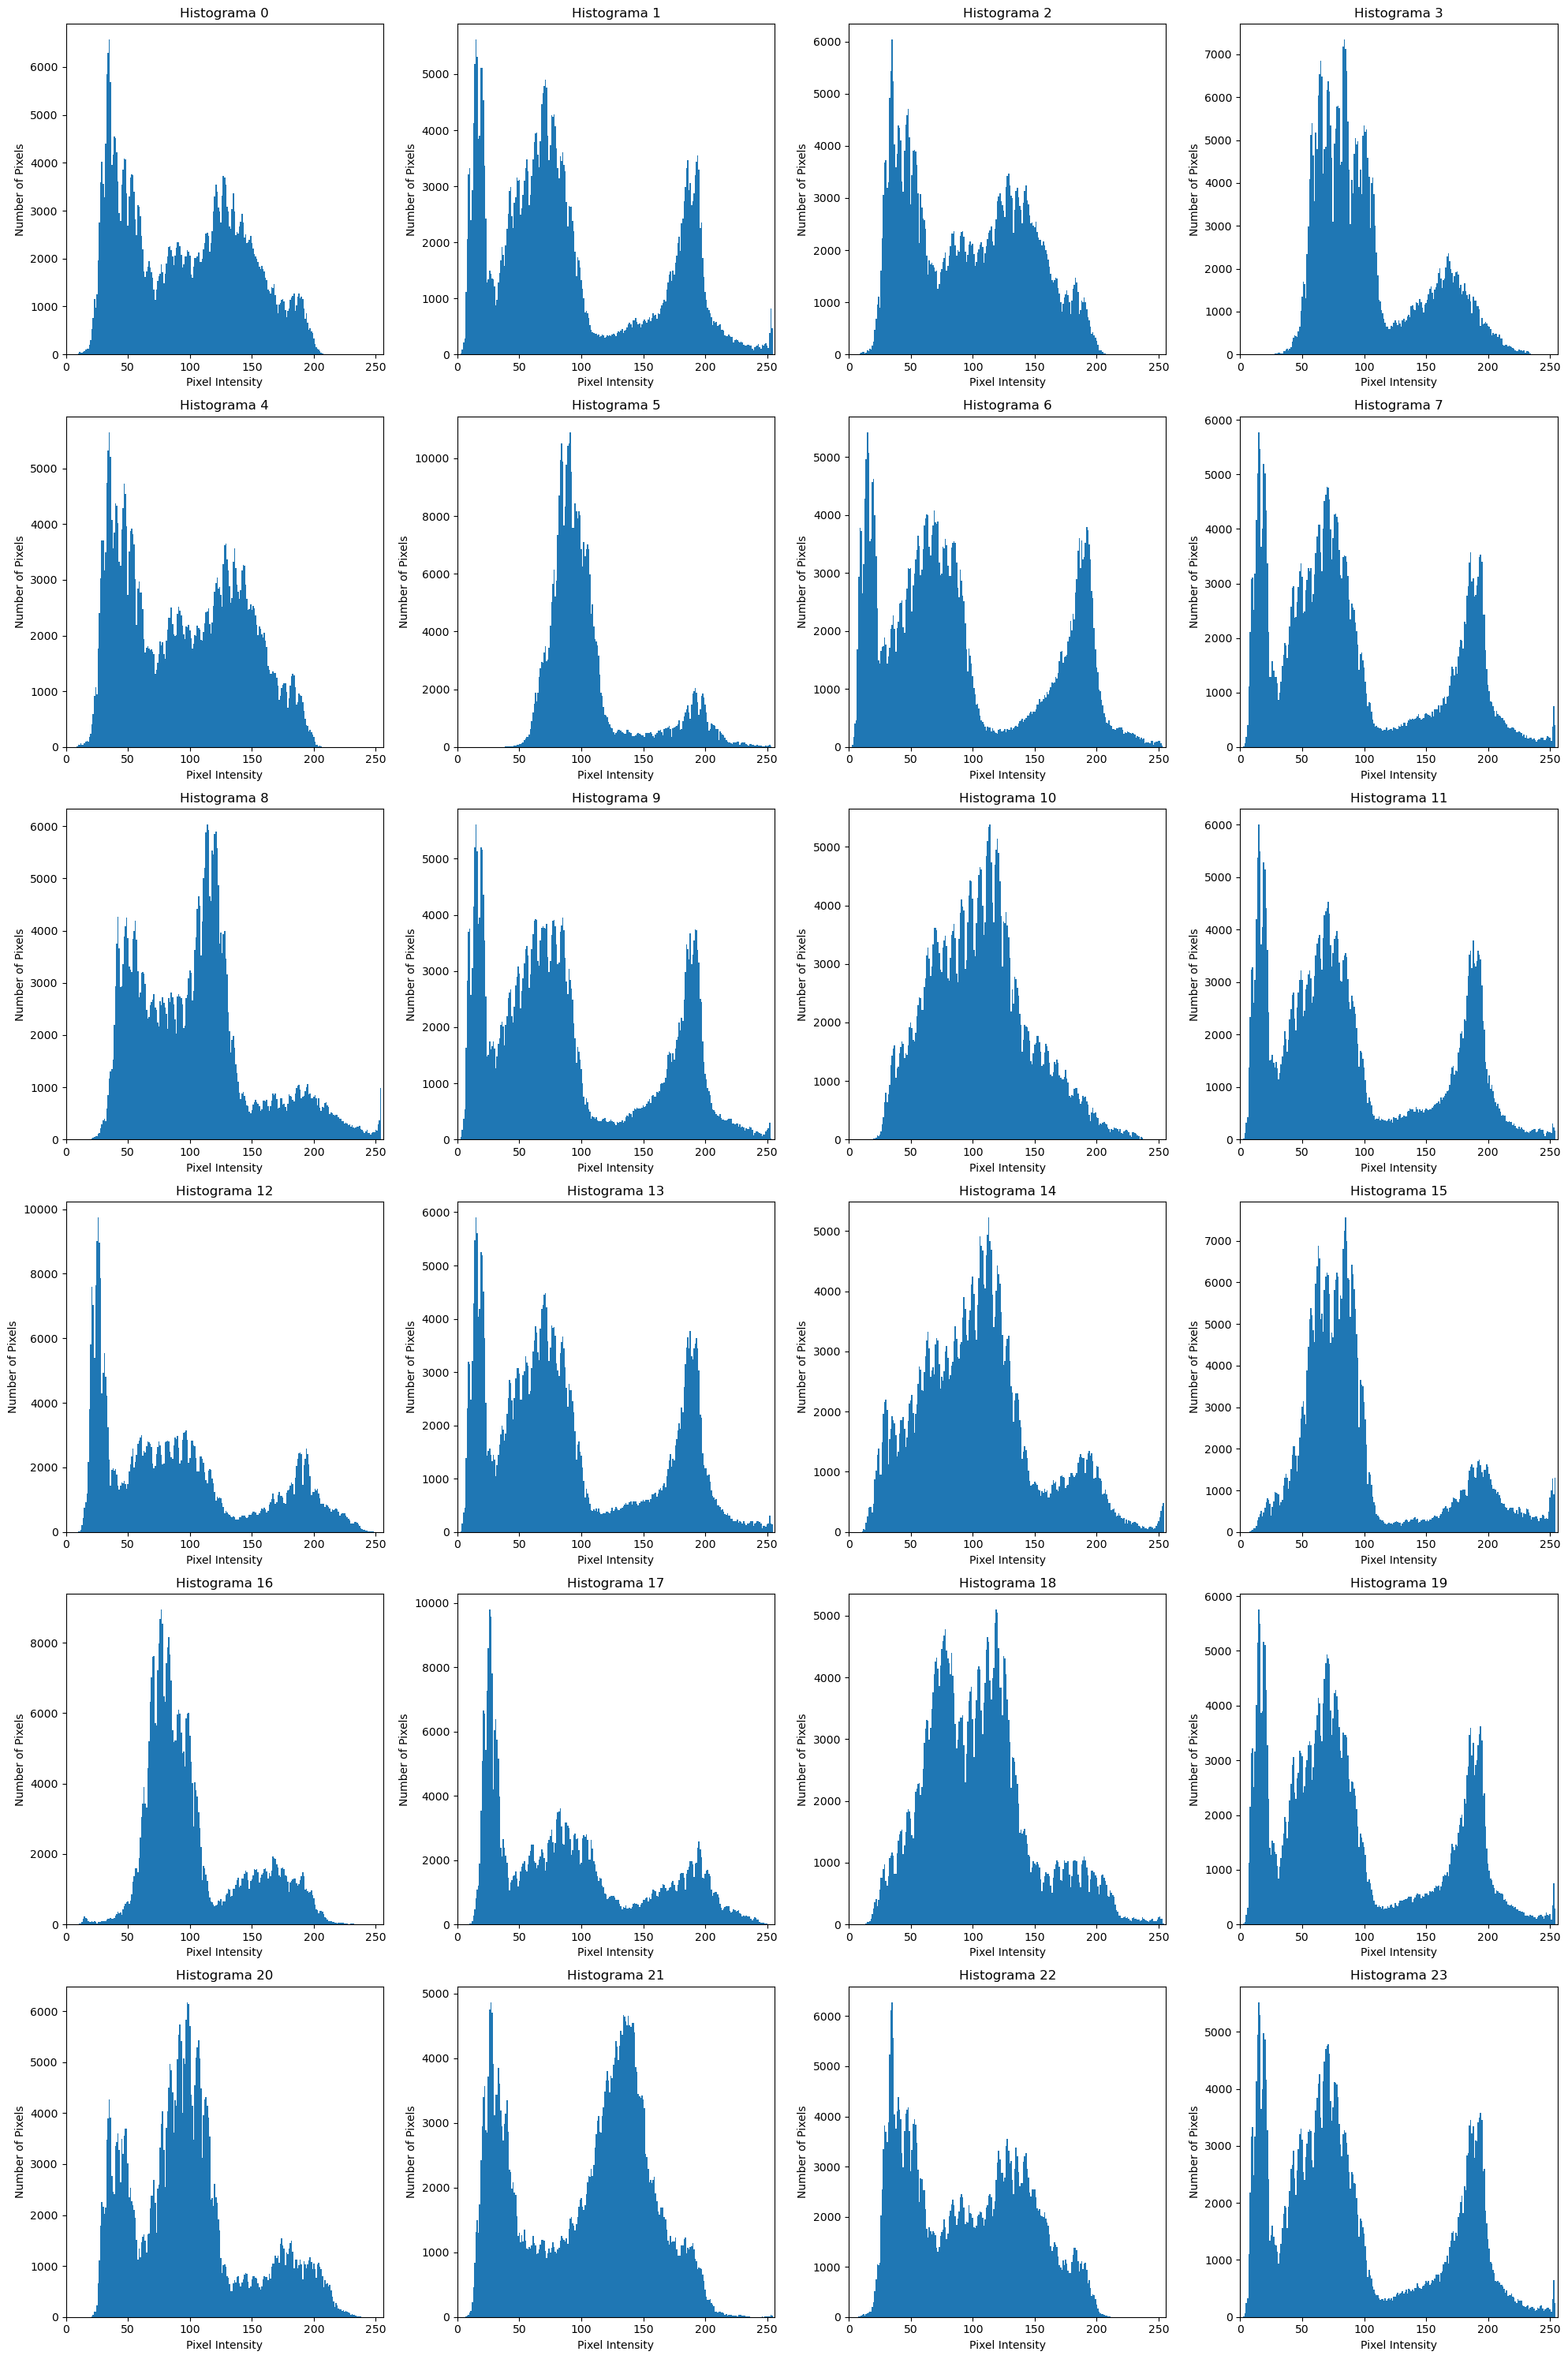

In [23]:
mostrar_histogramas(path_dataset_color, 'bn')

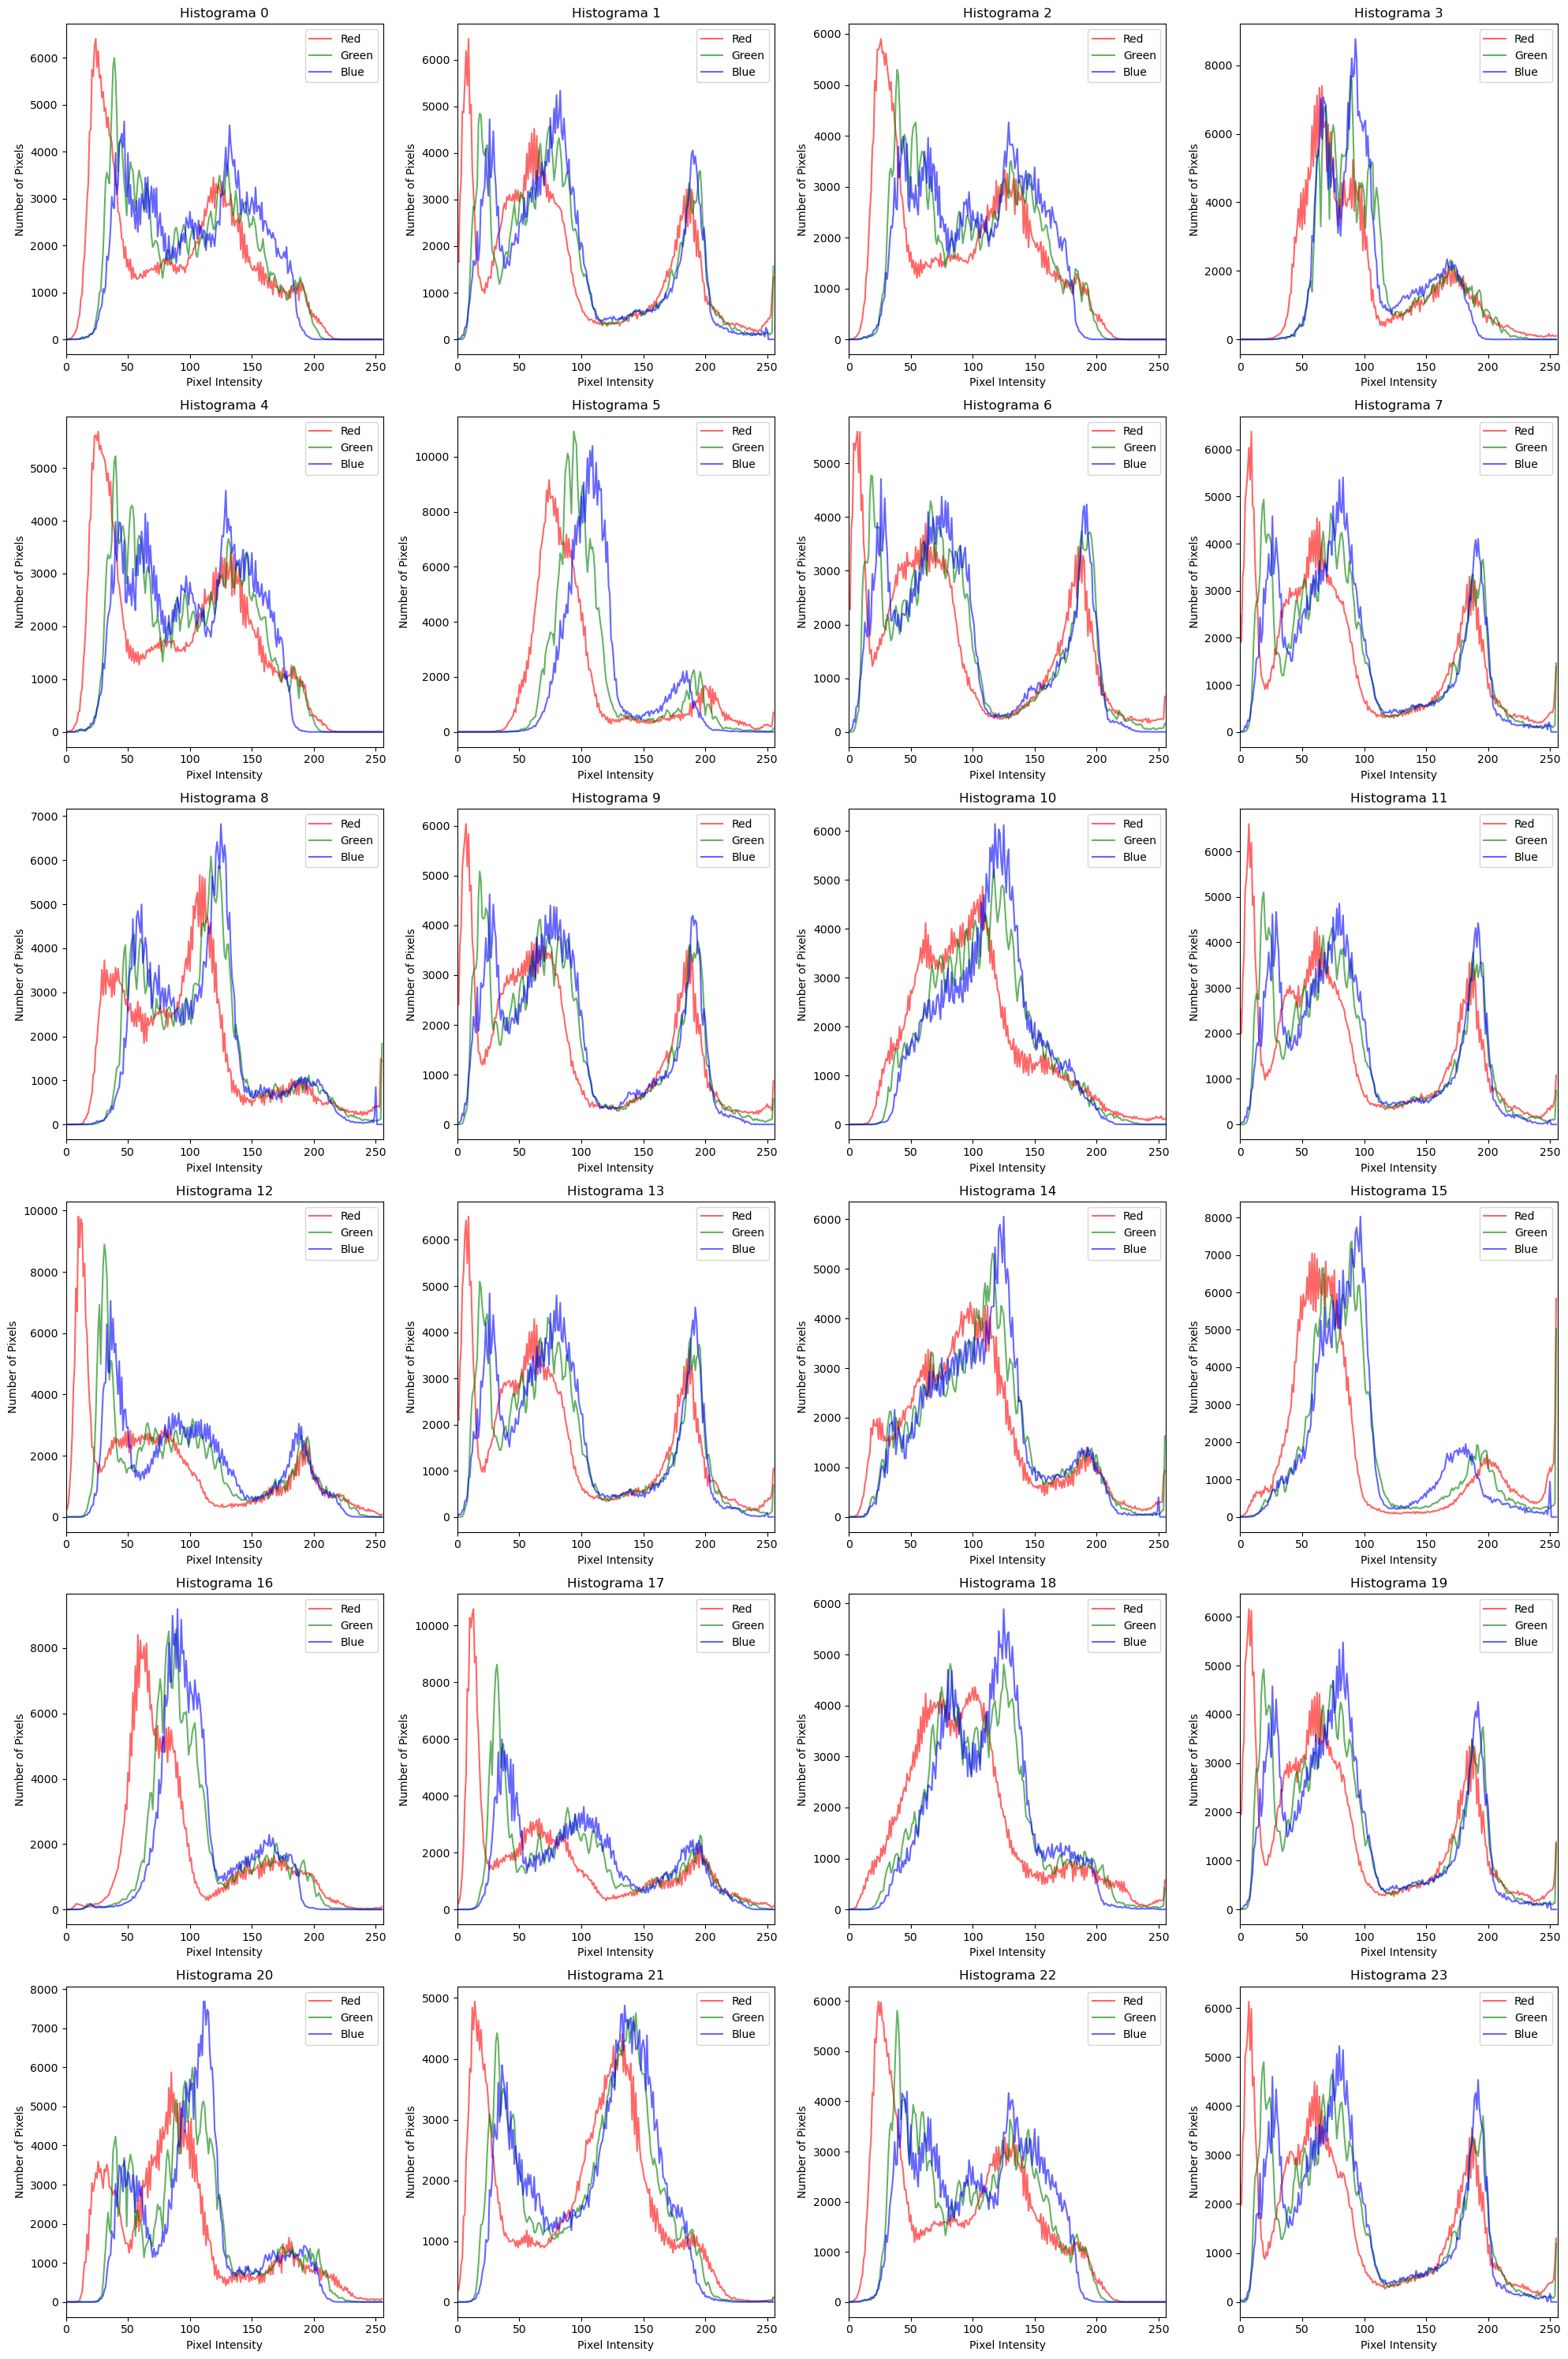

In [24]:
mostrar_histogramas(path_dataset_color, 'color')

## Fundamentos teóricos

Antes de continuar con el proyecto, vamos a recordar los diferentes procedimientos que podemos emplear al procesar las imágenes. Cabe destacar que para los diferentes procedimeintos venideros, se procesan las imágenes en escalas de grises para una mayor sencillez.

<style>
table {
    width: 100%;
    border-collapse: collapse;
    text-align: center;
}

th, td {
    padding: 10px;
    border: 1px solid #ccc;
}

th {
    background-color: #4CAF50;
    color: white;
}

td:nth-child(1) {
    background-color: #f9f9f9;
    font-weight: bold;
}

td:nth-child(2), td:nth-child(3), td:nth-child(4), td:nth-child(5) {
    background-color: #ffffff;
}

td:nth-child(5) {
    text-align: left;
}
</style>

| **Operación**             | **Nivel**     | **Lineal** | **Tipo**   | **Uso Principal**                                                |
|---------------------------|---------------|------------|------------|------------------------------------------------------------------|
| Ecualización de Histograma | Píxel         | No         | -          | Mejora el contraste redistribuyendo los niveles de intensidad de manera uniforme |
| CLAHE                      | Vecino        | No         | -          | Mejora el contraste localmente evitando la sobreexposición        |
| Filtro de Caja             | Vecino        | Sí         | Pasa-bajos | Suaviza la imagen, reduce el ruido eliminando detalles finos      |
| Filtro Gaussiano           | Vecino        | Sí         | Pasa-bajos | Suaviza la imagen, reduce el ruido preservando las estructuras de borde |
| Filtro Sobel               | Vecino        | Sí         | Pasa-altos | Detecta bordes destacando cambios de intensidad en direcciones específicas (x o y) |
| Filtro Laplaciano          | Vecino        | Sí         | Pasa-altos | Detecta bordes, mejora las transiciones rápidas de intensidad en todas direcciones |
| Filtro de Enfoque          | Vecino        | No         | Pasa-altos | Mejora la nitidez destacando bordes y detalles                   |
| Filtro Mediana             | Vecino        | No         | Pasa-bajos | Elimina ruido tipo *salt-pepper* preservando los bordes          |
| Filtro Bilateral           | Vecino        | No         | Pasa-bajos | Suaviza la imagen preservando los bordes, útil para reducción de ruido |



Para los procesos de binarización:

<table style="width:100%; border-collapse:collapse; color:#FFFFFF; background-color:#2D2D2D;">
  <tr style="background-color:#4A4A4A;">
    <th style="padding:10px; border:1px solid #666666;">Proceso</th>
    <th style="padding:10px; border:1px solid #666666;">Descripción</th>
    <th style="padding:10px; border:1px solid #666666;">Código de Ejemplo</th>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #666666;">Binarización Global</td>
    <td style="padding:10px; border:1px solid #666666;">Divide la imagen en dos regiones: blanco y negro, utilizando un único valor de umbral. Es útil cuando la imagen tiene una iluminación uniforme, pero puede no ser adecuado para imágenes con iluminación variable.</td>
    <td style="padding:10px; border:1px solid #666666;"><code>th, binary_mask = cv2.threshold(blurred, 118, 255, cv2.THRESH_BINARY)</code></td>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #666666;">Umbralización Adaptativa</td>
    <td style="padding:10px; border:1px solid #666666;">Calcula el umbral para cada píxel en función de una pequeña región a su alrededor. Se adapta a las condiciones de iluminación locales y produce mejores resultados para imágenes con iluminación variable. Se puede generar un umbral mediante la media del área vecina menos una constante (C), o una suma ponderada gaussiana de los valores del vecindario menos C.</td>
    <td style="padding:10px; border:1px solid #666666;"><code>binary_mask = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,5) # binary_mask = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15,5)</code></td>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #666666;">Método de Otsu</td>
    <td style="padding:10px; border:1px solid #666666;">Encuentra el valor de umbral que minimiza la varianza ponderada dentro de la clase. Es eficaz para separar objetos del fondo cuando hay una clara diferencia en los niveles de intensidad.</td>
    <td style="padding:10px; border:1px solid #666666;"><code>th, binary_mask = cv2.threshold(blurred, 118, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)</code></td>
  </tr>
</table>


Para las diferentes operaciones morfológicas:

<table style="width:100%; border-collapse:collapse; color:#000000; background-color:#f0f0f0;">
  <tr style="background-color:#c0c0c0;">
    <th style="padding:10px; border:1px solid #888888;">Operación Morfológica</th>
    <th style="padding:10px; border:1px solid #888888;">Descripción</th>
    <th style="padding:10px; border:1px solid #888888;">Código de Ejemplo</th>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #888888;">Dilatación</td>
    <td style="padding:10px; border:1px solid #888888;">Expande las regiones blancas en una imagen binaria. Aumenta el tamaño de los objetos y conecta regiones cercanas.</td>
    <td style="padding:10px; border:1px solid #888888;"><code>binary_mask_morph = cv2.dilate(binary_mask, kernel, iterations=1)</code></td>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #888888;">Erosión</td>
    <td style="padding:10px; border:1px solid #888888;">Reduce las regiones blancas en una imagen binaria. Disminuye el tamaño de los objetos y elimina detalles pequeños o ruido.</td>
    <td style="padding:10px; border:1px solid #888888;"><code>binary_mask_morph = cv2.erode(binary_mask, kernel, iterations=1)</code></td>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #888888;">Apertura</td>
    <td style="padding:10px; border:1px solid #888888;">Una erosión seguida de una dilatación con el mismo elemento estructurante. Elimina el ruido y los detalles pequeños, al tiempo que conserva la forma general de los objetos.</td>
    <td style="padding:10px; border:1px solid #888888;"><code>binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)</code></td>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #888888;">Cierre</td>
    <td style="padding:10px; border:1px solid #888888;">Una dilatación seguida de una erosión con el mismo elemento estructurante. Cierra pequeños agujeros en los objetos y suaviza los límites.</td>
    <td style="padding:10px; border:1px solid #888888;"><code>binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)</code></td>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #888888;">Gradiente Morfológico</td>
    <td style="padding:10px; border:1px solid #888888;">La diferencia entre la imagen dilatada y la imagen erosionada. Resalta los bordes de los objetos.</td>
    <td style="padding:10px; border:1px solid #888888;"><code>binary_mask_morph = cv2.subtract(binary_mask, cv2.erode(binary_mask, kernel, iterations=1))</code></td>
  </tr>
  <tr>
    <td style="padding:10px; border:1px solid #888888;">Umbralización</td>
    <td style="padding:10px; border:1px solid #888888;">Aunque no es una operación morfológica en sí misma, a menudo se utiliza para binarizar imágenes antes de aplicar operaciones morfológicas. Se pueden utilizar métodos de umbralización global, adaptativa o el método de Otsu para binarizar la imagen.</td>
    <td style="padding:10px; border:1px solid #888888;"><code>_, binary_mask_morph = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)</code></td>
  </tr>
</table>


## Metodos para los diferentes procesamientos

In [25]:
def calcular_metricas(mascara_original_binaria, binary_mask_morph):
    # Comparativa: calcular píxeles correcta e incorrectamente etiquetados
    pixeles_blancos_correctos = np.logical_and(mascara_original_binaria == 255, binary_mask_morph == 255)
    pixeles_negros_correctos = np.logical_and(mascara_original_binaria == 0, binary_mask_morph == 0)
    pixeles_blancos_incorrectos = np.logical_and(mascara_original_binaria == 255, binary_mask_morph == 0)
    pixeles_negros_incorrectos = np.logical_and(mascara_original_binaria == 0, binary_mask_morph == 255)
    total_pixeles = mascara_original_binaria.size

    # Calcular precisión, recall, F1-score y IoU
    TP = np.sum(pixeles_blancos_correctos)
    FP = np.sum(pixeles_negros_incorrectos)
    FN = np.sum(pixeles_blancos_incorrectos)
    TN = np.sum(pixeles_negros_correctos)

    accuracy = (TP + TN) / total_pixeles
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0

    return accuracy, precision, recall, f1_score, iou

def mostrar_resultados(axs, i, image_grey, blurred, binary_mask, binary_mask_morph, mascara_original):
    axs[i,0].imshow(image_grey, cmap='gray')
    axs[i,0].set_title('Imagen real')      
    axs[i,0].axis('off')

    axs[i,1].imshow(blurred, cmap='gray')
    axs[i,1].set_title('Preprocesamiento')
    axs[i,1].axis('off')

    axs[i,2].imshow(binary_mask, cmap='gray')
    axs[i,2].set_title('Binarización')
    axs[i,2].axis('off')

    axs[i,3].imshow(binary_mask_morph, cmap='gray')
    axs[i,3].set_title('Morfología')
    axs[i,3].axis('off')

    axs[i,4].imshow(mascara_original, cmap='gray')
    axs[i,4].set_title('Máscara original')
    axs[i,4].axis('off')

def imprimir_metricas(i, accuracy, precision, recall, f1_score, iou):
    print(f"Accuracy de la imagen {i+1:<2}: {accuracy:.4f}, precisión: {precision:.4f}, recall: {recall:.4f}, F1-score: {f1_score:.4f}, IoU: {iou:.4f}")

def imprimir_metricas_promedio(accuracies, precisions, recalls, f1_scores, ious):
    print("-"*100)
    print(f"Accuracy promedio procesamiento: {np.mean(accuracies):.2} ± {np.std(accuracies):.2}")
    print(f"Precisión promedio: {np.mean(precisions):.2f} ± {np.std(precisions):.2f}")
    print(f"Recall promedio: {np.mean(recalls):.2f} ± {np.std(recalls):.2f}")
    print(f"F1-score promedio: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}")
    print(f"IoU promedio: {np.mean(ious):.2f} ± {np.std(ious):.2f}")

## Primer procesamiento

In [26]:
def primer_process(path_imagenes, path_mascaras):
    archivos_imagenes = [f for f in os.listdir(path_imagenes) if os.path.isfile(os.path.join(path_imagenes, f))]
    
    extensiones = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    imagenes = [f for f in archivos_imagenes if os.path.splitext(f)[1].lower() in extensiones]

    archivos_mascaras = [f for f in os.listdir(path_mascaras) if os.path.isfile(os.path.join(path_mascaras, f))]
    imagenes_mascaras = [f for f in archivos_mascaras if os.path.splitext(f)[1].lower() in extensiones]

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    ious = []
    
    fig, axs = plt.subplots(24, 5, figsize=(9, 30))  
    
    for i, imagen in enumerate(imagenes[:len(imagenes_mascaras)]):

        ruta_imagen = os.path.join(path_imagenes, imagen)
        ruta_mascara = os.path.join(path_mascaras, imagenes_mascaras[i])

        image_grey = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
        mascara_original = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)

        # Preprocesamiento: Filtrado bilateral
        blurred = cv2.bilateralFilter(image_grey, 9, 75, 75)

        # Binarización global
        # th, binary_mask = cv2.threshold(blurred, 118, 255, cv2.THRESH_BINARY)
        th, binary_mask = cv2.threshold(blurred, 118, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # binary_mask = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,5)
        # binary_mask = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15,5)

        # Operaciones morfologicas
        kernel = np.ones((14, 14), np.uint8)
        binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        # binary_mask_morph = cv2.dilate(binary_mask, kernel, iterations=1)
        # binary_mask_morph = cv2.erode(binary_mask, kernel, iterations=1)
        # binary_mask_morph = cv2.subtract(binary_mask, cv2.erode(binary_mask, kernel, iterations=1))
        # binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        #_, binary_mask_morph = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)

        if np.array_equal(mascara_original, mascara_original // 255 * 255):
            mascara_original_binaria = mascara_original
        else:
            _, mascara_original_binaria = cv2.threshold(mascara_original, 118, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        accuracy, precision, recall, f1_score, iou = calcular_metricas(mascara_original_binaria, binary_mask_morph)

        accuracies.append((accuracy))
        precisions.append((precision))
        recalls.append((recall))
        f1_scores.append((f1_score))
        ious.append(iou)

        # Mostrar resultados en los subplots
        mostrar_resultados(axs, i, image_grey, blurred, binary_mask, binary_mask_morph, mascara_original)

        # Imprimir métricas
        imprimir_metricas(i, accuracy, precision, recall, f1_score, iou)

    # Imprimir métricas promedio
    imprimir_metricas_promedio(accuracies, precisions, recalls, f1_scores, ious)

    # Ajustar el layout de la figura
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  
    plt.show()

Accuracy de la imagen 1 : 0.7021, precisión: 0.4453, recall: 0.9289, F1-score: 0.6020, IoU: 0.4306
Accuracy de la imagen 2 : 0.9565, precisión: 0.8722, recall: 0.9793, F1-score: 0.9226, IoU: 0.8564
Accuracy de la imagen 3 : 0.7021, precisión: 0.4390, recall: 0.9334, F1-score: 0.5971, IoU: 0.4256
Accuracy de la imagen 4 : 0.9608, precisión: 0.9266, recall: 0.9266, F1-score: 0.9266, IoU: 0.8632
Accuracy de la imagen 5 : 0.7077, precisión: 0.4460, recall: 0.9339, F1-score: 0.6037, IoU: 0.4323
Accuracy de la imagen 6 : 0.9497, precisión: 0.9905, recall: 0.7633, F1-score: 0.8622, IoU: 0.7577
Accuracy de la imagen 7 : 0.9476, precisión: 0.8503, recall: 0.9773, F1-score: 0.9094, IoU: 0.8338
Accuracy de la imagen 8 : 0.9586, precisión: 0.8806, recall: 0.9778, F1-score: 0.9267, IoU: 0.8634
Accuracy de la imagen 9 : 0.6288, precisión: 0.3528, recall: 0.8972, F1-score: 0.5064, IoU: 0.3391
Accuracy de la imagen 10: 0.9587, precisión: 0.8824, recall: 0.9782, F1-score: 0.9279, IoU: 0.8654
Accuracy d

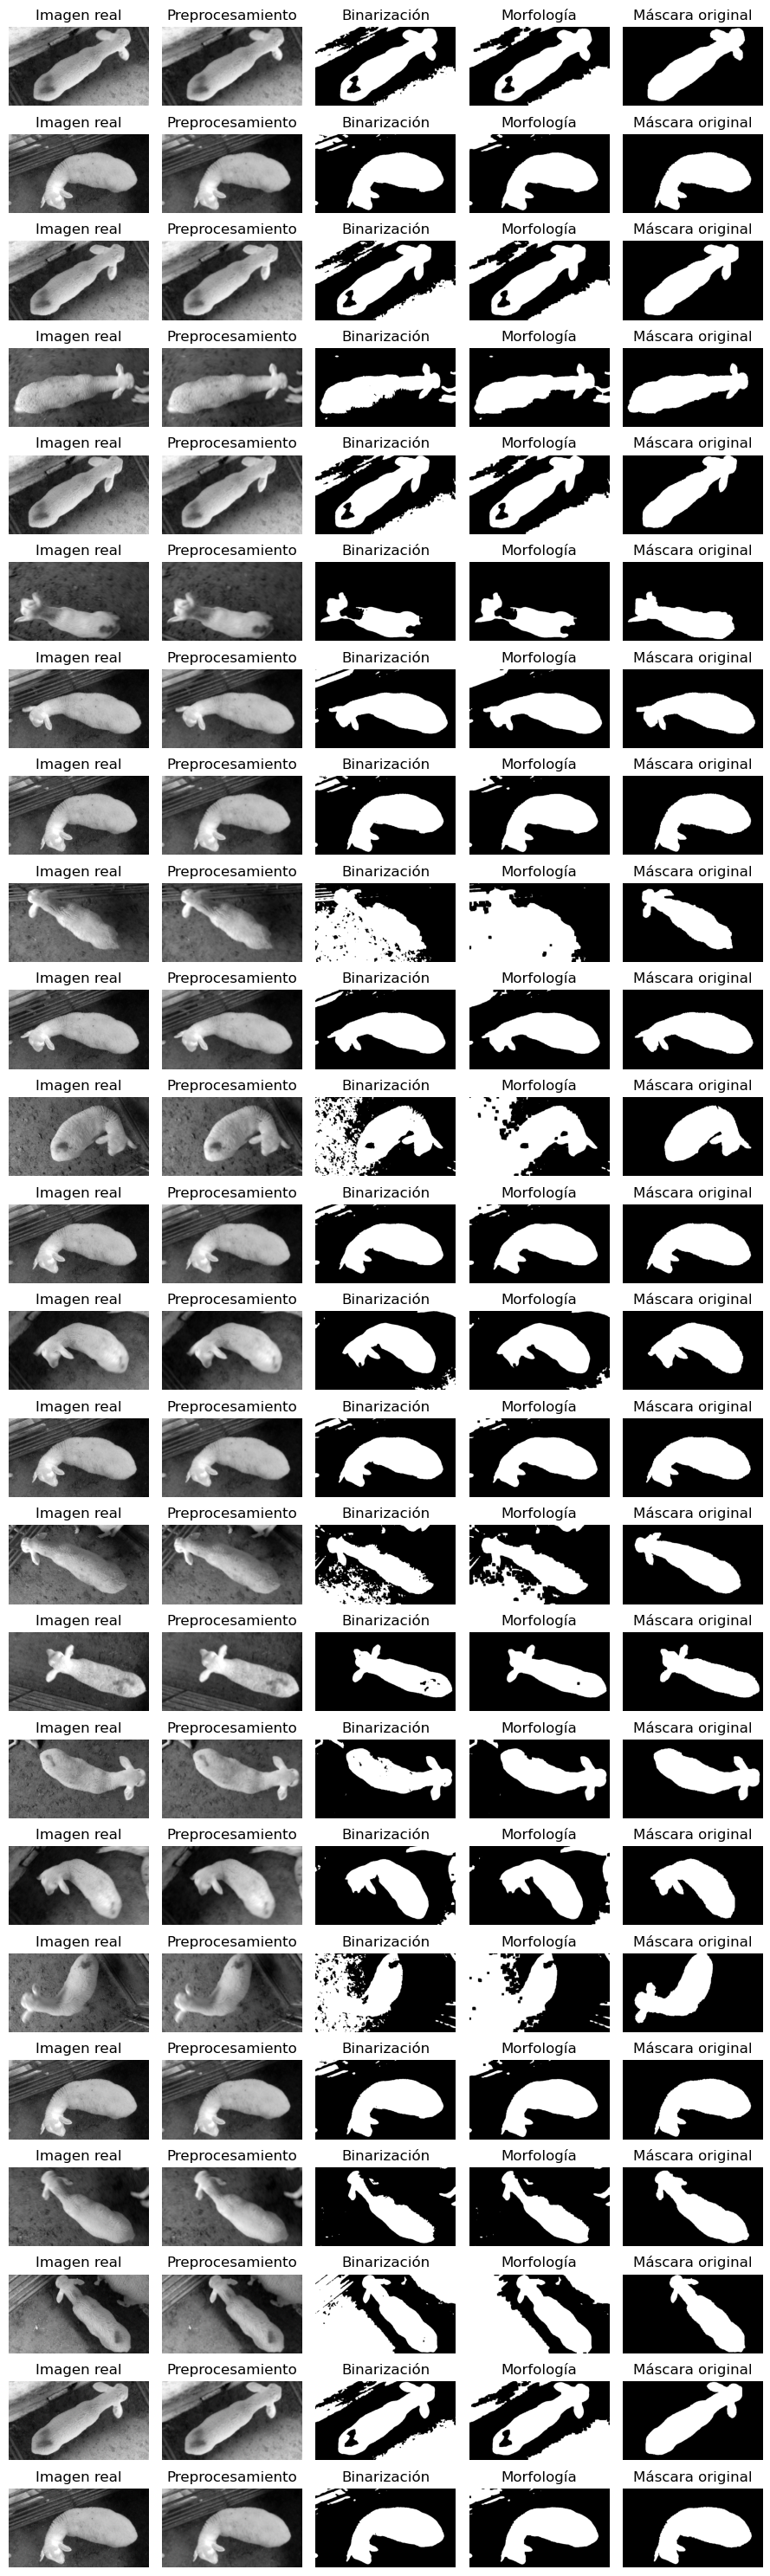

In [27]:
primer_process(path_dataset_color,path_dataset_mask)

## Segundo procesamiento

In [28]:
def segundo_process(path_imagenes, path_mascaras):
    archivos_imagenes = [f for f in os.listdir(path_imagenes) if os.path.isfile(os.path.join(path_imagenes, f))]
    
    extensiones = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    imagenes = [f for f in archivos_imagenes if os.path.splitext(f)[1].lower() in extensiones]

    archivos_mascaras = [f for f in os.listdir(path_mascaras) if os.path.isfile(os.path.join(path_mascaras, f))]
    imagenes_mascaras = [f for f in archivos_mascaras if os.path.splitext(f)[1].lower() in extensiones]

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    ious = []
    
    fig, axs = plt.subplots(24, 5, figsize=(9, 30))  
    
    for i, imagen in enumerate(imagenes[:len(imagenes_mascaras)]):

        ruta_imagen = os.path.join(path_imagenes, imagen)
        ruta_mascara = os.path.join(path_mascaras, imagenes_mascaras[i])

        image_grey = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
        mascara_original = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)

        # Preprocesamiento: Filtrado bilateral
        blurred = cv2.filter2D(image_grey, -1, np.array([[1/16, 2/16, 1/16],[2/16, 4/16, 2/16],[1/16, 2/16, 1/16]]))

        # Binarización global
        th, binary_mask = cv2.threshold(blurred, 118, 255, cv2.THRESH_BINARY)
        # th, binary_mask = cv2.threshold(blurred, 118, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # binary_mask = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,5)
        # binary_mask = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15,5)

        # Operaciones morfologicas
        kernel = np.ones((15, 15), np.uint8)
        # binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        # binary_mask_morph = cv2.dilate(binary_mask, kernel, iterations=1)
        # binary_mask_morph = cv2.erode(binary_mask, kernel, iterations=1)
        # binary_mask_morph = cv2.subtract(binary_mask, cv2.erode(binary_mask, kernel, iterations=1))
        binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        #_, binary_mask_morph = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)


        if np.array_equal(mascara_original, mascara_original // 255 * 255):
            mascara_original_binaria = mascara_original
        else:
            _, mascara_original_binaria = cv2.threshold(mascara_original, 118, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        accuracy, precision, recall, f1_score, iou = calcular_metricas(mascara_original_binaria, binary_mask_morph)

        accuracies.append((accuracy))
        precisions.append((precision))
        recalls.append((recall))
        f1_scores.append((f1_score))
        ious.append(iou)

        # Mostrar resultados en los subplots
        mostrar_resultados(axs, i, image_grey, blurred, binary_mask, binary_mask_morph, mascara_original)

        # Imprimir métricas
        imprimir_metricas(i, accuracy, precision, recall, f1_score, iou)

    # Imprimir métricas promedio
    imprimir_metricas_promedio(accuracies, precisions, recalls, f1_scores, ious)

    # Ajustar el layout de la figura
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  
    plt.show()

Accuracy de la imagen 1 : 0.7969, precisión: 0.5574, recall: 0.7902, F1-score: 0.6537, IoU: 0.4856
Accuracy de la imagen 2 : 0.9755, precisión: 0.9342, recall: 0.9760, F1-score: 0.9547, IoU: 0.9133
Accuracy de la imagen 3 : 0.7998, precisión: 0.5513, recall: 0.8242, F1-score: 0.6607, IoU: 0.4933
Accuracy de la imagen 4 : 0.9592, precisión: 0.9297, recall: 0.9166, F1-score: 0.9231, IoU: 0.8572
Accuracy de la imagen 5 : 0.8074, precisión: 0.5655, recall: 0.8283, F1-score: 0.6721, IoU: 0.5062
Accuracy de la imagen 6 : 0.9635, precisión: 0.9724, recall: 0.8470, F1-score: 0.9054, IoU: 0.8271
Accuracy de la imagen 7 : 0.9603, precisión: 0.8863, recall: 0.9780, F1-score: 0.9299, IoU: 0.8689
Accuracy de la imagen 8 : 0.9762, precisión: 0.9374, recall: 0.9761, F1-score: 0.9564, IoU: 0.9164
Accuracy de la imagen 9 : 0.8812, precisión: 0.6855, recall: 0.8134, F1-score: 0.7440, IoU: 0.5923
Accuracy de la imagen 10: 0.9715, precisión: 0.9215, recall: 0.9782, F1-score: 0.9490, IoU: 0.9030
Accuracy d

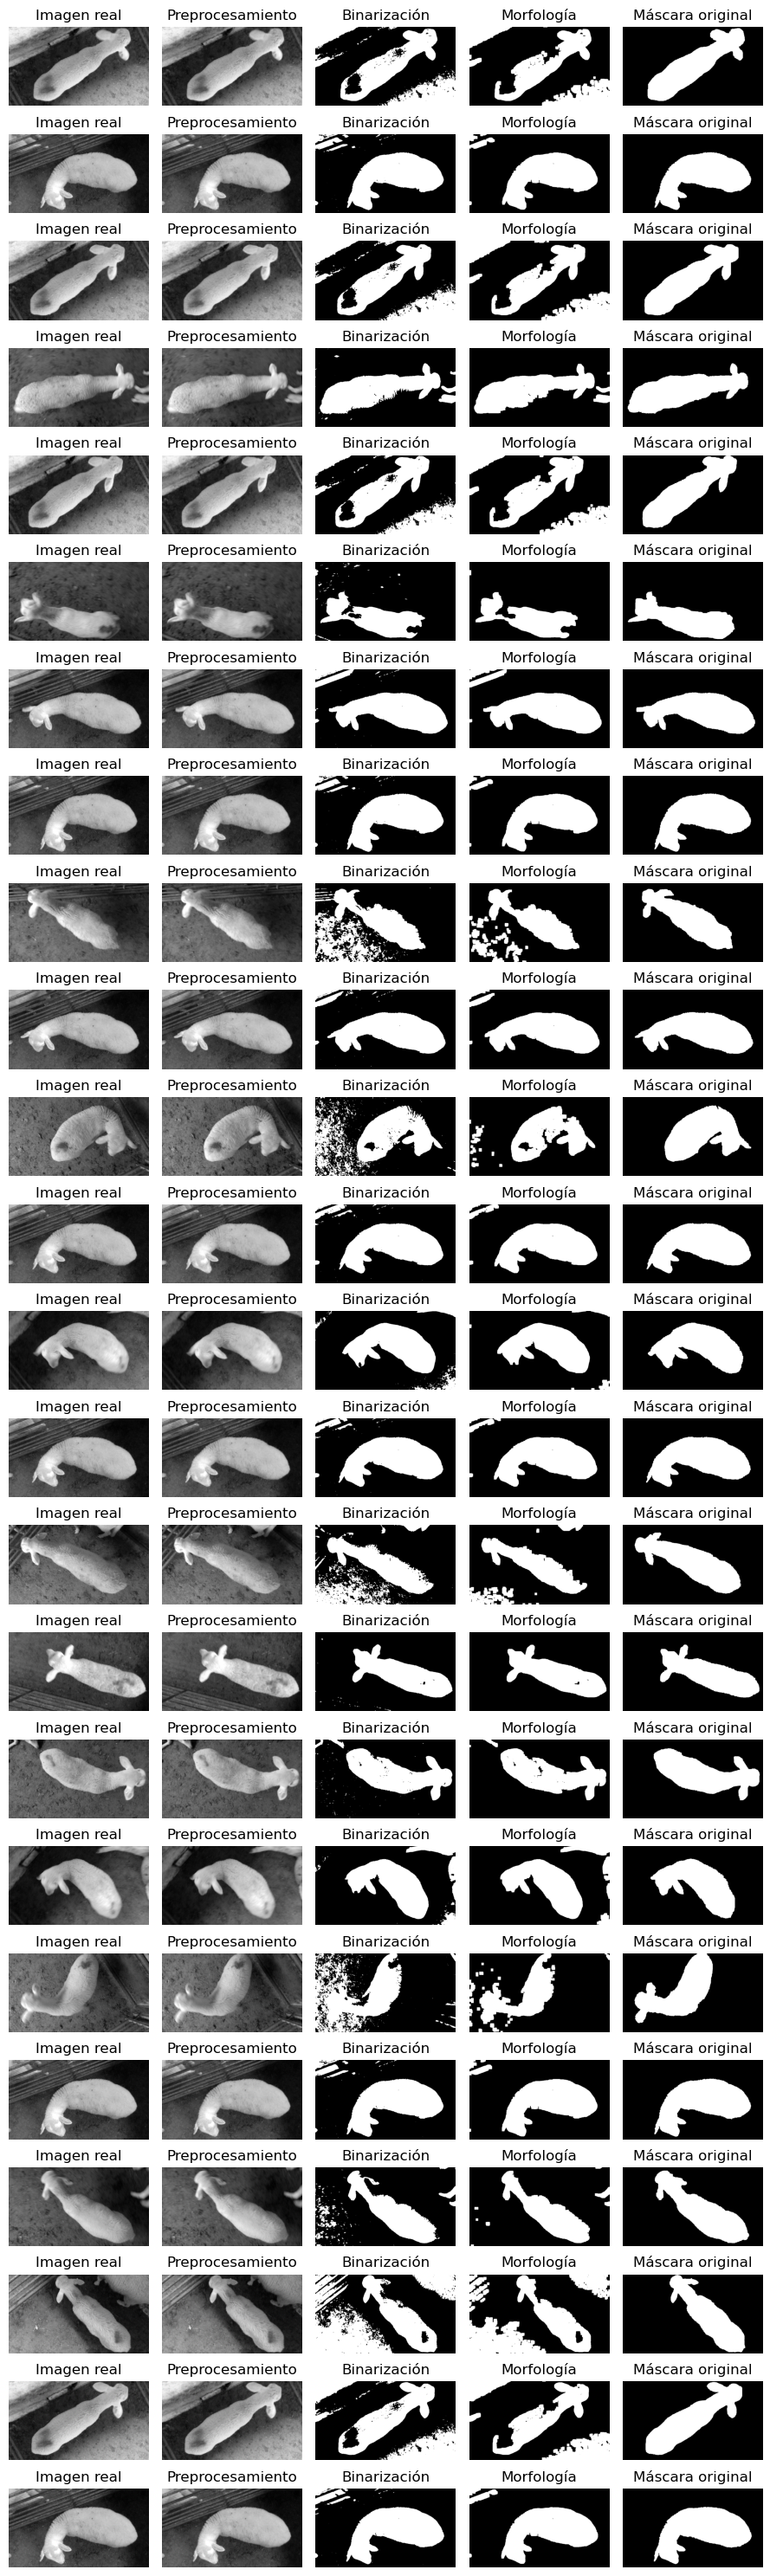

In [29]:
segundo_process(path_dataset_color,path_dataset_mask)

## Tercer procesamineto

In [30]:
def tercer_process(path_imagenes, path_mascaras):
    archivos_imagenes = [f for f in os.listdir(path_imagenes) if os.path.isfile(os.path.join(path_imagenes, f))]
    
    extensiones = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    imagenes = [f for f in archivos_imagenes if os.path.splitext(f)[1].lower() in extensiones]

    archivos_mascaras = [f for f in os.listdir(path_mascaras) if os.path.isfile(os.path.join(path_mascaras, f))]
    imagenes_mascaras = [f for f in archivos_mascaras if os.path.splitext(f)[1].lower() in extensiones]

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    ious = []
    
    fig, axs = plt.subplots(24, 5, figsize=(9, 30))  
    
    for i, imagen in enumerate(imagenes[:len(imagenes_mascaras)]):

        ruta_imagen = os.path.join(path_imagenes, imagen)
        ruta_mascara = os.path.join(path_mascaras, imagenes_mascaras[i])

        image_grey = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
        mascara_original = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)

        # Preprocesamiento: Filtrado bilateral
        blurred = cv2.medianBlur(image_grey, 7)

        # Binarización global
        th, binary_mask = cv2.threshold(blurred, 118, 255, cv2.THRESH_BINARY)
        # th, binary_mask = cv2.threshold(blurred, 118, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # binary_mask = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,5)
        # binary_mask = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,15,5)

        # Operaciones morfologicas
        kernel = np.ones((14, 14), np.uint8)
        # binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        # binary_mask_morph = cv2.dilate(binary_mask, kernel, iterations=1)
        # binary_mask_morph = cv2.erode(binary_mask, kernel, iterations=1)
        # binary_mask_morph = cv2.subtract(binary_mask, cv2.erode(binary_mask, kernel, iterations=1))
        binary_mask_morph = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
        #_, binary_mask_morph = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)


        if np.array_equal(mascara_original, mascara_original // 255 * 255):
            mascara_original_binaria = mascara_original
        else:
            _, mascara_original_binaria = cv2.threshold(mascara_original, 118, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        accuracy, precision, recall, f1_score, iou = calcular_metricas(mascara_original_binaria, binary_mask_morph)

        accuracies.append((accuracy))
        precisions.append((precision))
        recalls.append((recall))
        f1_scores.append((f1_score))
        ious.append(iou)

        # Mostrar resultados en los subplots
        mostrar_resultados(axs, i, image_grey, blurred, binary_mask, binary_mask_morph, mascara_original)

        # Imprimir métricas
        imprimir_metricas(i, accuracy, precision, recall, f1_score, iou)

    # Imprimir métricas promedio
    imprimir_metricas_promedio(accuracies, precisions, recalls, f1_scores, ious)

    # Ajustar el layout de la figura
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  
    plt.show()

Accuracy de la imagen 1 : 0.7900, precisión: 0.5447, recall: 0.8198, F1-score: 0.6545, IoU: 0.4864
Accuracy de la imagen 2 : 0.9715, precisión: 0.9188, recall: 0.9787, F1-score: 0.9478, IoU: 0.9008
Accuracy de la imagen 3 : 0.7905, precisión: 0.5363, recall: 0.8422, F1-score: 0.6553, IoU: 0.4873
Accuracy de la imagen 4 : 0.9637, precisión: 0.9303, recall: 0.9341, F1-score: 0.9322, IoU: 0.8730
Accuracy de la imagen 5 : 0.7968, precisión: 0.5480, recall: 0.8425, F1-score: 0.6641, IoU: 0.4971
Accuracy de la imagen 6 : 0.9644, precisión: 0.9720, recall: 0.8521, F1-score: 0.9081, IoU: 0.8316
Accuracy de la imagen 7 : 0.9570, precisión: 0.8762, recall: 0.9786, F1-score: 0.9246, IoU: 0.8597
Accuracy de la imagen 8 : 0.9724, precisión: 0.9230, recall: 0.9787, F1-score: 0.9500, IoU: 0.9048
Accuracy de la imagen 9 : 0.8495, precisión: 0.6077, recall: 0.8209, F1-score: 0.6984, IoU: 0.5366
Accuracy de la imagen 10: 0.9683, precisión: 0.9103, recall: 0.9796, F1-score: 0.9437, IoU: 0.8934
Accuracy d

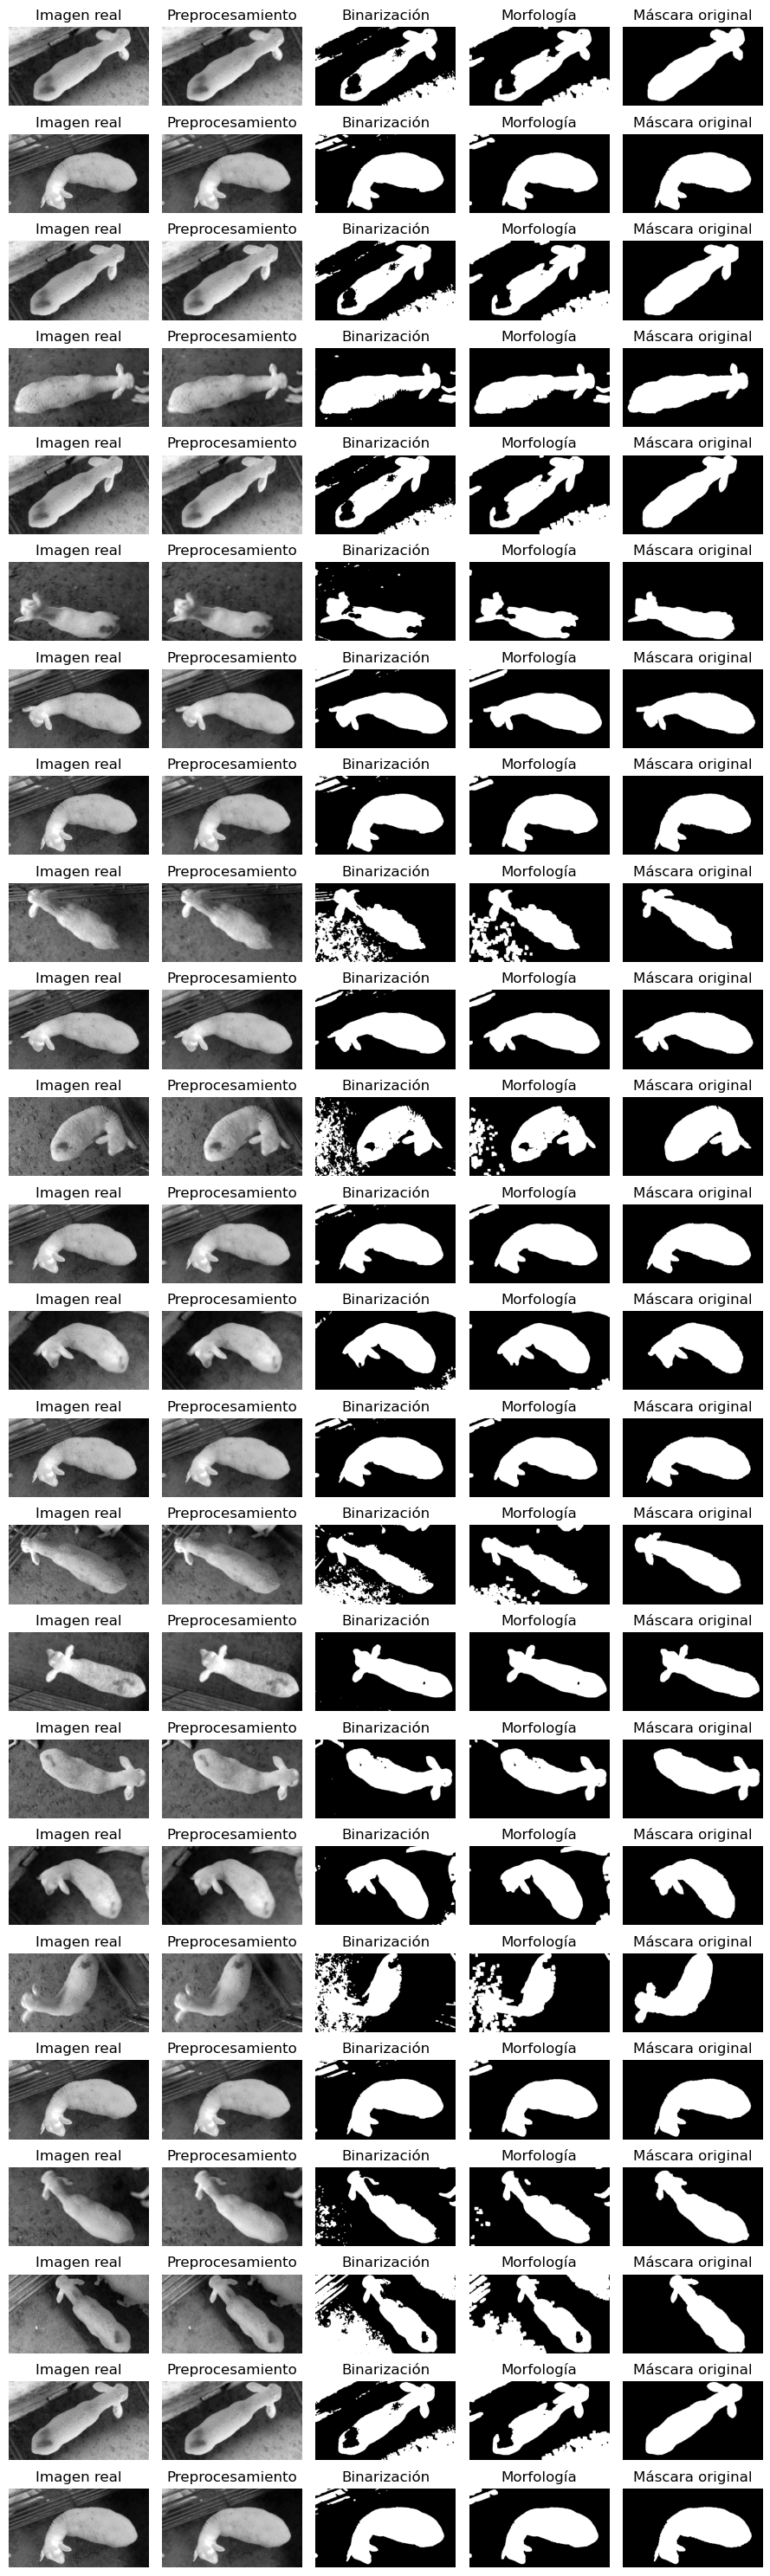

In [31]:
tercer_process(path_dataset_color, path_dataset_mask)